# Where to open a new coffee shop?

## 📖 Background
You are helping a client who owns coffee shops in Colorado. The company's coffee shops serve high-quality and responsibly sourced coffee,  pastries, and sandwiches. They operate three locations in Fort Collins and want to expand into Denver. 

Your client believes that the ideal location for a new store is close to affluent households, and the store appeals to the 20-35 year old demographic.
 
Your team collected geographical and demographic information about Denver's neighborhoods to assist the search. They also collected data for Starbucks stores in Denver. Starbucks and the new coffee shops do not compete for the same clients; the team included their location as a reference.

## 💾 The data
You have assembled information from three different sources ([locations](https://github.com/chrismeller/), [neighborhoods](http://data.denvergov.org), [demographics](https://www.census.gov/)):

#### Starbucks locations in Denver, Colorado
- "StoreNumber" - Store Number as assigned by Starbucks
- "Name" - Name identifier for the store
- "PhoneNumber" - Phone number for the store
- "Street 1, 2, and 3" - Address for the store
- "PostalCode" - Zip code of the store
- "Longitude, Latitude" - Coordinates of the store

#### Neighborhoods' geographical information
- "NBHD_ID" - Neighborhood ID (matches the census information)
- "NBHD_NAME" - Name of the statistical neighborhood
- "Geometry" - Polygon that defines the neighborhood

#### Demographic information
- "NBHD_ID" - Neighborhood ID (matches the geographical information)
- "NBHD_NAME' - Nieghborhood name
- "POPULATION_2010' - Population in 2010
- "AGE_ " - Number of people in each age bracket (< 18, 18-34, 35-65, and > 65)
- "NUM_HOUSEHOLDS" - Number of households in the neighborhood
- "FAMILIES" - Number of families in the neighborhood
- "NUM_HHLD_100K+" - Number of households with income above 100 thousand USD per year

_Starbucks locations were scrapped from the Starbucks store locator webpage by [Chris Meller](https://github.com/chrismeller/)._  
_Statistical Neighborhood information from the [City of Denver Open Data Catalog](http://data.denvergov.org), [CC BY 3.0](http://creativecommons.org/licenses/by/3.0/) license._      
_Census information from the [United States Census Bureau](https://www.census.gov/). Publicly available information._

## 💪 Challenge
Provide your client a list of neighborhoods in Denver where they should consider expanding. Include:
* A visualization of Denver's neighborhoods and the Starbucks store locations.
* Find the neighborhoods with the highest proportion of people in the target demographic.
* Select the top three neighborhoods where your client should focus their search.

# Data Collection and Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import mapping, Point
import folium

sns.set_style('whitegrid')

In [2]:
denver_data = pd.read_csv('./data/denver.csv')
census_data = pd.read_csv('./data/census.csv')
neighborhoods = gpd.read_file('./data/neighborhoods.shp')

In [3]:
neighborhoods['center'] = neighborhoods.geometry.centroid
part = ['NBHD_NAME', 'center']
neighborhood_centers = neighborhoods[part]
neighborhood_one = neighborhoods.loc[neighborhoods.NBHD_NAME == "Auraria"]
center_point = neighborhood_one.center[0]
neighborhood_center = [center_point.y, center_point.x]

## Check Values

In [4]:
# Check for missing values in census data
census_data.isnull().sum()

# Check for missing values in Denver Starbucks data
denver_data.isnull().sum()

# Convert necessary columns to appropriate data types
census_data['POPULATION_2010'] = census_data['POPULATION_2010'].astype(float)
census_data['AGE_LESS_18'] = census_data['AGE_LESS_18'].astype(float)
census_data['AGE_18_TO_34'] = census_data['AGE_18_TO_34'].astype(float)
census_data['AGE_35_TO_65'] = census_data['AGE_35_TO_65'].astype(float)
census_data['AGE_65_PLUS'] = census_data['AGE_65_PLUS'].astype(float)
census_data['NUM_HOUSEHOLDS'] = census_data['NUM_HOUSEHOLDS'].astype(float)
census_data['FAMILIES'] = census_data['FAMILIES'].astype(float)
census_data['NUM_HHLD_100K+'] = census_data['NUM_HHLD_100K+'].astype(float)

# Convert longitude and latitude to float
#denver_data['Longitude'] = denver_data['Longitude'].astype(float)
#denver_data['Latitude'] = denver_data['Latitude'].astype(float)

# Display cleaned data
census_data.info(), denver_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NBHD_ID          78 non-null     int64  
 1   NBHD_NAME        78 non-null     object 
 2   POPULATION_2010  78 non-null     float64
 3   AGE_LESS_18      78 non-null     float64
 4   AGE_18_TO_34     78 non-null     float64
 5   AGE_35_TO_65     78 non-null     float64
 6   AGE_65_PLUS      78 non-null     float64
 7   NUM_HOUSEHOLDS   78 non-null     float64
 8   FAMILIES         78 non-null     float64
 9   NUM_HHLD_100K+   48 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 6.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StoreNumber  78 non-null     object 
 1   Name         78 non-null     object 
 2   PhoneNum

(None, None)

## Null values

In [5]:
census_data.isnull().sum()

NBHD_ID             0
NBHD_NAME           0
POPULATION_2010     0
AGE_LESS_18         0
AGE_18_TO_34        0
AGE_35_TO_65        0
AGE_65_PLUS         0
NUM_HOUSEHOLDS      0
FAMILIES            0
NUM_HHLD_100K+     30
dtype: int64

In [6]:
# Assume null instances of NUM_HHLD_100K+ == 0
median_val = census_data['NUM_HHLD_100K+'].median()

census_data['NUM_HHLD_100K+'] = census_data['NUM_HHLD_100K+'].fillna(median_val)

# EDA

## Distribution

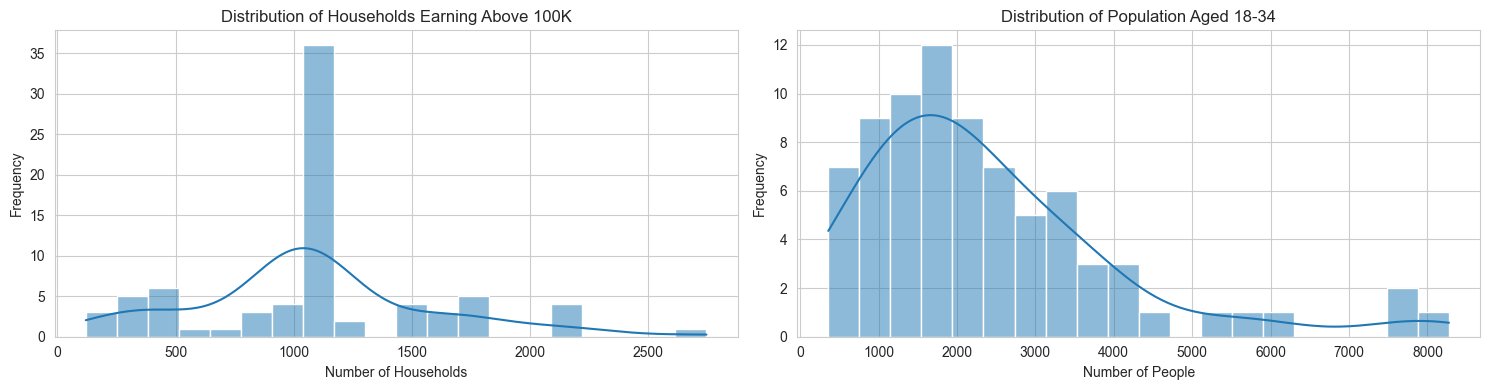

In [7]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 4))

# Histogram for households earning above 100K
plt.subplot(1, 2, 1)
sns.histplot(census_data['NUM_HHLD_100K+'], bins=20, kde=True)
plt.title('Distribution of Households Earning Above 100K')
plt.xlabel('Number of Households')
plt.ylabel('Frequency')

# Histogram for population aged 18-34
plt.subplot(1, 2, 2)
sns.histplot(census_data['AGE_18_TO_34'], bins=20, kde=True)
plt.title('Distribution of Population Aged 18-34')
plt.xlabel('Number of People')
plt.ylabel('Frequency')

# Show plots
plt.tight_layout()
plt.show()

/Users/brettlill/.pyenv/versions/3.10.6/envs/lang-env/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


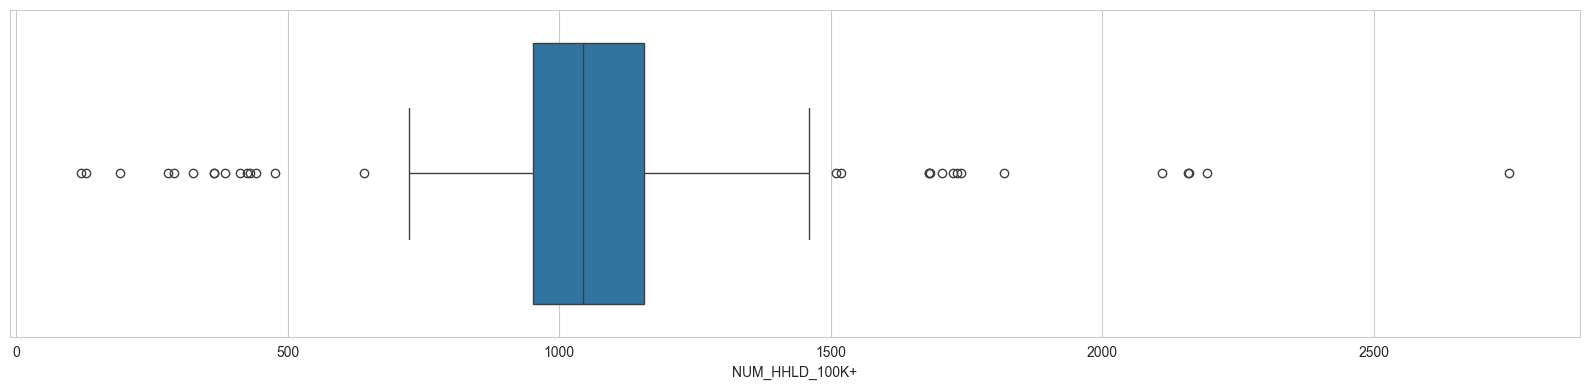

In [8]:
plt.figure(figsize = (16, 4))
sns.boxplot(data = census_data, x = 'NUM_HHLD_100K+')
plt.tight_layout()

# Ranking Neighborhoods based on Target Variables

## 18 to 34 Year Olds

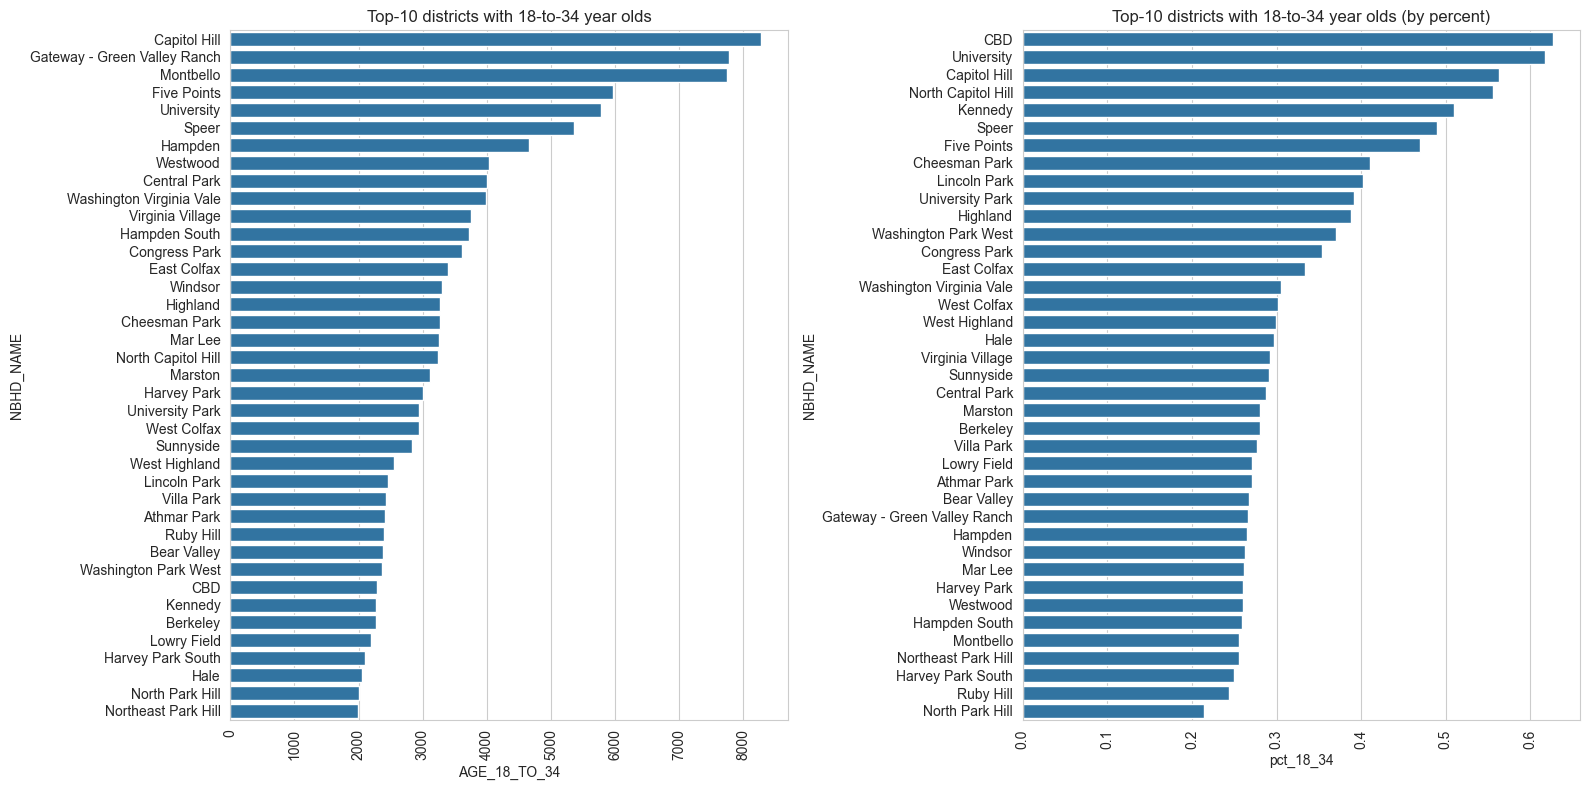

In [9]:
plt.figure(figsize = (16, 8))

df = census_data.copy()
df['pct_100K+'] = df['NUM_HHLD_100K+'] / df['NUM_HOUSEHOLDS']
df['pct_less_18'] = df['AGE_LESS_18'] / df['POPULATION_2010']
df['pct_18_34'] = df['AGE_18_TO_34'] / df['POPULATION_2010']

df1 = df[df['AGE_18_TO_34'] > df['AGE_18_TO_34'].median()]
df1 = df1.sort_values(by = 'AGE_18_TO_34', ascending = False)

plt.subplot(1, 2, 1)
sns.barplot(data = df1, y = 'NBHD_NAME', x = 'AGE_18_TO_34')
plt.title("Top-10 districts with 18-to-34 year olds")
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2)
df1 = df1.sort_values(by= 'pct_18_34', ascending = False)
sns.barplot(data = df1, y = 'NBHD_NAME', x = 'pct_18_34')
plt.title("Top-10 districts with 18-to-34 year olds (by percent)")
plt.xticks(rotation = 90)

plt.tight_layout()

In [10]:
m = folium.Map(location=neighborhood_center, zoom_start=12)

# geodf
n_demogeo = df1.merge(neighborhoods, on='NBHD_NAME', how = 'inner')
geodf = gpd.GeoDataFrame(n_demogeo, crs = {'init': 'epsg:4326'}, geometry = n_demogeo.geometry)
geodf = geodf[['NBHD_NAME','geometry','pct_18_34']]

# Add a Choropleth layer
folium.Choropleth(
    geo_data=geodf,             # GeoDataFrame or the path to your GeoJSON file
    data=geodf,                 # DataFrame or Series that contains the data
    columns=['NBHD_NAME', 'pct_18_34'],  # Columns for neighborhood name and the data to visualize
    key_on='feature.properties.NBHD_NAME',  # Path in GeoJSON dataset to match 'NBHD_NAME' in DataFrame
    fill_color='Blues',        # Fill color, choose based on preference
    fill_opacity=0.7,         # Fill opacity
    line_opacity=0.2,         # Line opacity
    legend_name='Age 18 to 34 As Pct '  # Legend title
).add_to(m)

# Display the map
m

/Users/brettlill/.pyenv/versions/3.10.6/envs/lang-env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## 100K+ Households

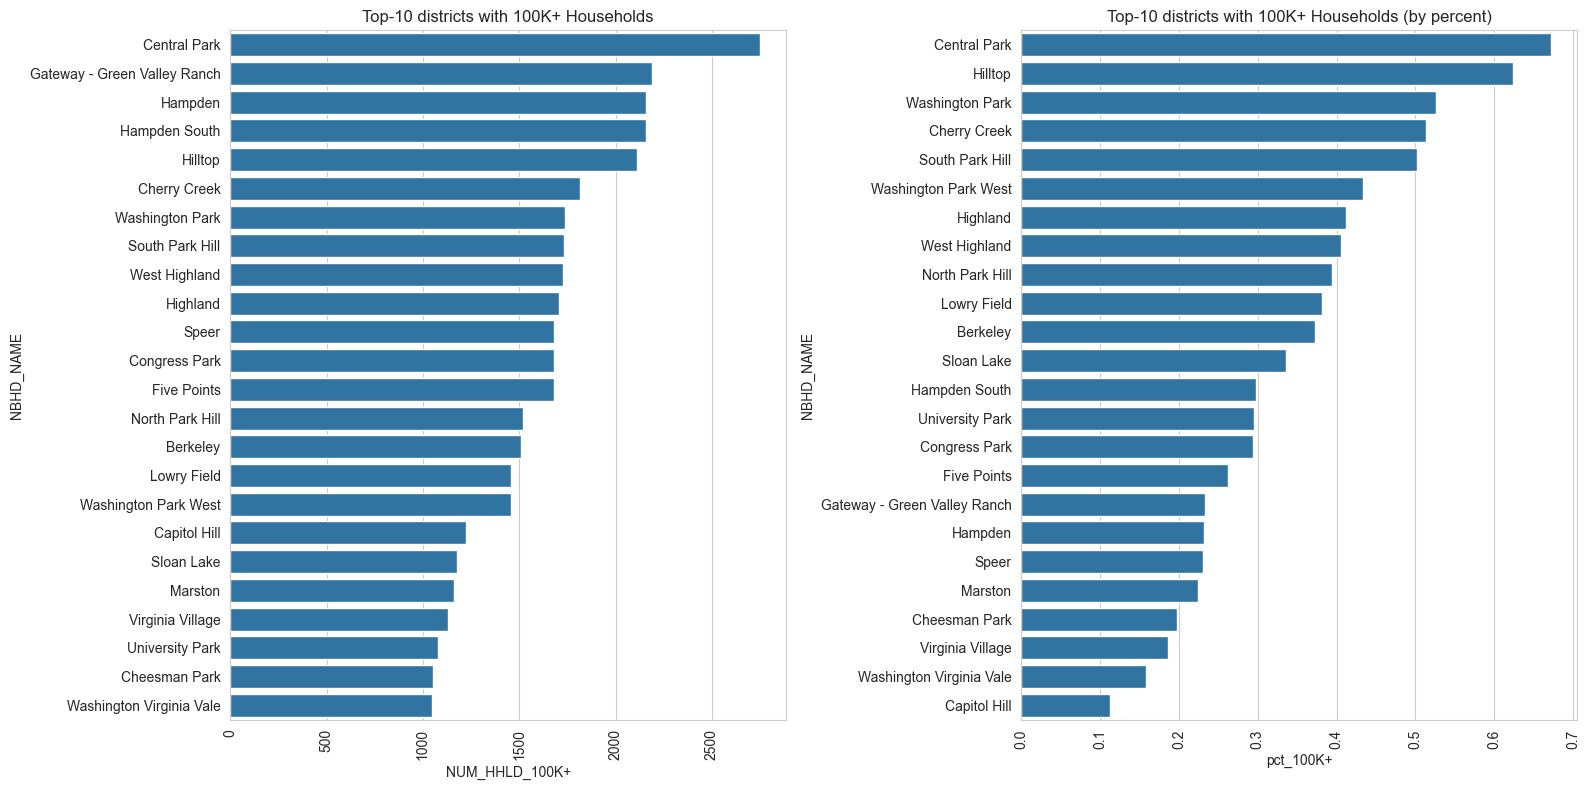

In [11]:
plt.figure(figsize = (16, 8))

df = census_data.copy()
df['pct_100K+'] = df['NUM_HHLD_100K+'] / df['NUM_HOUSEHOLDS']
df['pct_less_18'] = df['AGE_LESS_18'] / df['POPULATION_2010']
df['pct_18_34'] = df['AGE_18_TO_34'] / df['POPULATION_2010']

df1 = df[df['NUM_HHLD_100K+'] > df['NUM_HHLD_100K+'].median()]
df1 = df1.sort_values(by = 'NUM_HHLD_100K+', ascending = False)

plt.subplot(1, 2, 1)
sns.barplot(data = df1, y = 'NBHD_NAME', x = 'NUM_HHLD_100K+')
plt.title("Top-10 districts with 100K+ Households")
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2)
df1 = df1.sort_values(by= 'pct_100K+', ascending = False)
sns.barplot(data = df1, y = 'NBHD_NAME', x = 'pct_100K+')
plt.title("Top-10 districts with 100K+ Households (by percent)")
plt.xticks(rotation = 90)

plt.tight_layout()

In [12]:
m = folium.Map(location=neighborhood_center, zoom_start=12)

# geodf
n_demogeo = df1.merge(neighborhoods, on='NBHD_NAME', how = 'inner')
geodf = gpd.GeoDataFrame(n_demogeo, crs = {'init': 'epsg:4326'}, geometry = n_demogeo.geometry)
geodf = geodf[['NBHD_NAME','geometry','NUM_HHLD_100K+']]

# Add a Choropleth layer
folium.Choropleth(
    geo_data=geodf,             # GeoDataFrame or the path to your GeoJSON file
    data=geodf,                 # DataFrame or Series that contains the data
    columns=['NBHD_NAME', 'NUM_HHLD_100K+'],  # Columns for neighborhood name and the data to visualize
    key_on='feature.properties.NBHD_NAME',  # Path in GeoJSON dataset to match 'NBHD_NAME' in DataFrame
    fill_color='Blues',        # Fill color, choose based on preference
    fill_opacity=0.7,         # Fill opacity
    line_opacity=0.2,         # Line opacity
    legend_name='100K+ Households'  # Legend title
).add_to(m)

# Display the map
m

/Users/brettlill/.pyenv/versions/3.10.6/envs/lang-env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Finding the Top-3 Neighborhoods

**Composite Score Formula**
The composite score is calculated as a weighted average of the above components. This balances the impact of proportions and absolute numbers, ensuring that neighborhoods with both high proportions and high absolute numbers are prioritized.

**Weighting**
- Proportion_Affluent (30%): Reflects the relative concentration of affluent households.
- Proportion_18_34 (30%): Reflects the relative concentration of the target age demographic.
- Normalized Affluent Households (20%): Ensures neighborhoods with more affluent households are prioritized.
- Normalized Population Aged 18-34 (20%): Ensures neighborhoods with a larger target demographic are prioritized.

**Minimum Thresholds**
- At least affluent households higher than column median
- At least aged 18-34 count higher than column median

In [21]:
# Find median affluent HHLD count
median_100K = census_data['NUM_HHLD_100K+'].median()
median_age_18_34 = census_data['AGE_18_TO_34'].median()

# Filter neighborhoods based on minimum thresholds
filtered_neighborhoods = census_data[(census_data['NUM_HHLD_100K+'] >= median_100K) & 
                                     (census_data['AGE_18_TO_34'] >= median_age_18_34)].reset_index(drop = True)

# Calculate the proportion of affluent households
filtered_neighborhoods['Proportion_Affluent'] = filtered_neighborhoods['NUM_HHLD_100K+'] / filtered_neighborhoods['NUM_HOUSEHOLDS']

# Calculate the proportion of people aged 18-34
filtered_neighborhoods['Proportion_18_34'] = filtered_neighborhoods['AGE_18_TO_34'] / filtered_neighborhoods['POPULATION_2010']

# Calculate a composite score
filtered_neighborhoods['Composite_Score'] = (0.3 * filtered_neighborhoods['Proportion_Affluent'] +
                                             0.3 * filtered_neighborhoods['Proportion_18_34'] +
                                             0.2 * (filtered_neighborhoods['NUM_HHLD_100K+'] / filtered_neighborhoods['NUM_HHLD_100K+'].max()) +
                                             0.2 * (filtered_neighborhoods['AGE_18_TO_34'] / filtered_neighborhoods['AGE_18_TO_34'].max()))

# Sort the neighborhoods based on the composite score
target_neighborhoods = filtered_neighborhoods.sort_values(by='Composite_Score', ascending=False).head(3)

#target_neighborhoods_improved
target_neighborhoods[['NBHD_ID','NBHD_NAME','Composite_Score']]

,NBHD_ID,NBHD_NAME,Composite_Score
15,60,Central Park,0.584554
6,28,Gateway - Green Valley Ranch,0.497210
1,9,Capitol Hill,0.491572


In [22]:
target_ids = target_neighborhoods['NBHD_ID'].to_list()
census_data['Target'] = census_data['NBHD_ID'].isin(target_ids)
filtered_neighborhoods['Target'] = filtered_neighborhoods['NBHD_ID'].isin(target_ids).reset_index(drop = True)

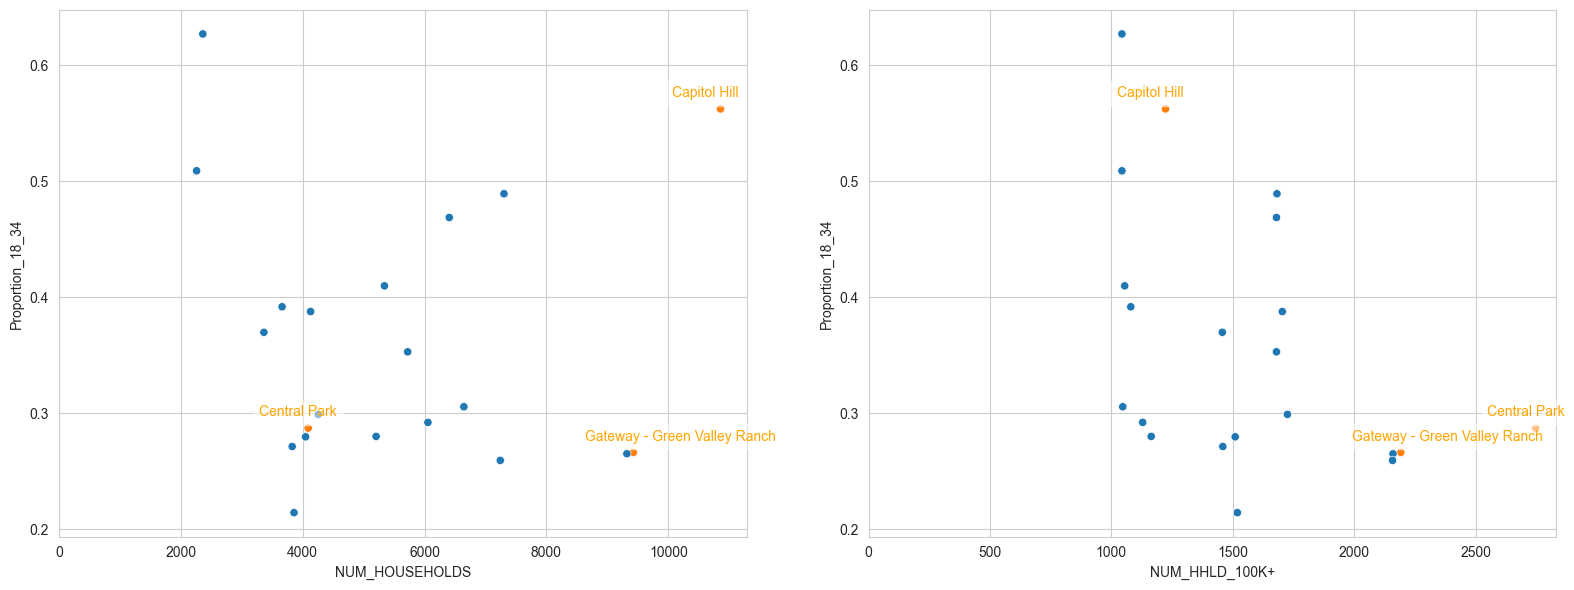

In [15]:
df = filtered_neighborhoods.copy()

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
ax = sns.scatterplot(data = df, x = 'NUM_HOUSEHOLDS', y = 'Proportion_18_34', hue = 'Target')

# Annotate each point in the scatter plot
for i in range(len(df)):
    if df['Target'].iloc[i]:
        ax.text(x=df['NUM_HOUSEHOLDS'].iloc[i] - 800, y=df['Proportion_18_34'].iloc[i] + 0.01, s=df['NBHD_NAME'].iloc[i], 
                 fontdict=dict(color='orange', size=10), 
                 bbox=dict(facecolor='white', alpha=0.5))
plt.xlim(0)
plt.legend().remove()


plt.subplot(1, 2, 2)
ax = sns.scatterplot(data = df, x = 'NUM_HHLD_100K+', y = 'Proportion_18_34', hue = 'Target')

# Annotate each point in the scatter plot
for i in range(len(df)):
    if df['Target'].iloc[i]:
        ax.text(x=df['NUM_HHLD_100K+'].iloc[i] - 200, y=df['Proportion_18_34'].iloc[i] + 0.01, s=df['NBHD_NAME'].iloc[i], 
                 fontdict=dict(color='orange', size=10), 
                 bbox=dict(facecolor='white', alpha=0.5))

plt.xlim(0)
plt.legend().remove()
plt.tight_layout()

## Selected Neighborhoods

In [20]:
target_neighborhoods.drop('NBHD_ID', axis = 1)

,NBHD_NAME,POPULATION_2010,AGE_LESS_18,AGE_18_TO_34,AGE_35_TO_65,AGE_65_PLUS,NUM_HOUSEHOLDS,FAMILIES,NUM_HHLD_100K+,Proportion_Affluent,Proportion_18_34,Composite_Score
59,Central Park,13948.0,3516.0,4008.0,6045.0,379.0,4092.0,2759.0,2748.0,0.671554,0.287353,0.584554
27,Gateway - Green Valley Ranch,29201.0,10074.0,7778.0,10405.0,944.0,9427.0,7056.0,2192.0,0.232524,0.266361,0.497210
8,Capitol Hill,14708.0,408.0,8274.0,5155.0,871.0,10856.0,1201.0,1223.0,0.112657,0.562551,0.491572
